In [1]:
import flapjack as flap
import loica as lc
import sbol3
from sbol_utilities import component

import numpy as np
import getpass
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
user = input()
passwd = getpass.getpass()
#fj = flap.flapjack.Flapjack('localhost:8000')
fj = flap.flapjack.Flapjack('flapjack.rudge-lab.org:8000')
fj.log_in(username=user, password=passwd)

tim
········


# NOR gate

In [ ]:
nor = lc.GeneticNetwork(vector=0)

ahl1 = lc.Supplement(name='AHL1')
ahl2 = lc.Supplement(name='AHL2')

tetr_reg = lc.Regulator(name='TetR', degradation_rate=0)
laci_reg = lc.Regulator(name='LacI', degradation_rate=0)
nor.add_regulator([tetr_reg, laci_reg])

gfp_rep = lc.Reporter(name='GFP', degradation_rate=0, signal_id=0 , color='green')
nor.add_reporter(gfp_rep)

ahl1_not_tetr_gfp = lc.Receiver(name='pAhl1', input=ahl1, output=[tetr_reg], alpha=[0.1, 10000], K=10, n=2)
ahl2_not_laci = lc.Receiver(name='pAhl2', input=ahl2, output=laci_reg, alpha=[0.1, 10000], K=10, n=2)
tetr_laci_nor_gfp = lc.Hill2(name='pTet', input=[tetr_reg, laci_reg], output=gfp_rep, alpha=[10000, 10000,0.1, 0.1], K=[10, 10], n=[2,2])
nor.add_operator([ahl1_not_tetr_gfp, ahl2_not_laci,tetr_laci_nor_gfp])

plt.figure(figsize=(3.3,3.3), dpi=300)
nor.draw()

In [ ]:
plt.figure(figsize=(3.3,3.3), dpi=300)
nor.draw(contracted=True)

In [ ]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism('LOICA metab', biomass, growth_rate)

# Create list of samples    
samples = []
for conc1 in np.logspace(-3, 3, 12):
    for conc2 in np.logspace(-3, 3, 12):
        sample = lc.Sample(genetic_network=nor, metabolism=metab)
        # Add AHL to samples at given concentration
        sample.set_supplement(ahl1, conc1)
        sample.set_supplement(ahl2, conc2)
        samples.append(sample)

assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='LOICA ahl NOR gate',
              description='Simulated NOR gate generated by LOICA',
              biomass_signal_id=0
             )
assay.run()

# NOR gate connected to Flapjack

In [ ]:

dna = fj.create('dna', name='ahl_nor_gate')

vector = fj.create('vector', name='ahl_nor_gate_plasmid', dnas=dna.id[0])   

study = fj.create('study', name='ahl_nor_study', description='Test for demonstration')

media = fj.create('media', name='Loica LB', description='Simulated loica media')

strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfps = fj.create('signal', name='SGFP', color='green', description='Simulated green fluorescent protein')

biomass_signal = fj.get('signal', name='OD')

In [ ]:
nor = lc.GeneticNetwork(vector=vector.id[0])

ahl1 = lc.Supplement(name='AHL1')
ahl2 = lc.Supplement(name='AHL2')

tetr_reg = lc.Regulator(name='TetR', degradation_rate=0)
laci_reg = lc.Regulator(name='LacI', degradation_rate=0)
nor.add_regulator([tetr_reg, laci_reg])

gfp_rep = lc.Reporter(name='GFP', degradation_rate=0, signal_id=gfps.id[0] , color='green')
nor.add_reporter(gfp_rep)

ahl1_not_tetr_gfp = lc.Receiver(name='pAhl1', input=ahl1, output=[tetr_reg], alpha=[0.1, 10000], K=10, n=2)
ahl2_not_laci = lc.Receiver(name='pAhl2', input=ahl2, output=laci_reg, alpha=[0.1, 10000], K=10, n=2)
tetr_laci_nor_gfp = lc.Hill2(name='NOR', input=[tetr_reg, laci_reg], output=gfp_rep, alpha=[10000, 1e-2, 1e-2, 1e-4], K=[10, 10], n=[2,2])
nor.add_operator([ahl1_not_tetr_gfp, ahl2_not_laci,tetr_laci_nor_gfp])

plt.figure(figsize=(3.3,3.3), dpi=300)
nor.draw()

In [ ]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism('LOICA metab', biomass, growth_rate)

# Create list of samples    
samples = []
for conc1 in np.logspace(-3, 3, 12):
    for conc2 in np.logspace(-3, 3, 12):
        sample = lc.Sample(genetic_network=nor, metabolism=metab,
                           media=media.id[0], strain=strain.id[0])
        # Add AHL to samples at given concentration
        sample.set_supplement(ahl1, conc1)
        sample.set_supplement(ahl2, conc2)
        samples.append(sample)

assay = lc.Assay(samples, 
              n_measurements=100, 
              interval=0.25,
              name='LOICA ahl NOR gate',
              description='Simulated NOR gate generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

In [ ]:
assay.upload(fj, study.id[0])

# Repressilator

In [ ]:

dna = fj.create('dna', name='Rep_simple')

vector = fj.create('vector', name='Rep_plasmid', dnas=dna.id)   

study = fj.create('study', name='Simple_repressilator', description='Test for demonstration')

media = fj.create('media', name='Loica LB', description='Simulated loica media')

strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
gfps = fj.create('signal', name='SGFP', color='green', description='Simulated green fluorescent protein')

biomass_signal = fj.get('signal', name='OD')

In [ ]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

ptet, ptet_seq = component.promoter('L3S2P21_UPA20_pTetR_RiboJ','GTCCCTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTtccctatcagtgatagagattgacatccctatcagtgatagagatactgagcacatcagcaggacgcactgaccAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin pTet (based on B-P27-pTetR-F1)')
plac, plac_seq = component.promoter('L3S2P11_UPA20_pLac_RiboJ10', 'GTCCCTCGGTACCAAATTCCAGAAAAGAGACGCTTTCGAGCGTCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTcctttcgtcttcacctcgagaattgtgagcggataacaattgacattgtgagcggataacaagatactgagcacatcagcaggacgcactgaccgaattcattAGCGCTCAACGGGTGTGCTTCCCGTTCTGATGAGTCCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin pLac (based on B-P39-pLac-F2)')
plam, plam_seq = component.promoter('L3S1P13_UPA20_plambda_RiboJ51', 'GTCCGACGAACAATAAGGCCTCCCTAACGGGGGGCCTTTTTTATTGATAACAAAAGTGCCTACTCTGGAAAATCTccgccgccctagacctagctgcaggtcgaggataaatatctaacaccgtgcgtgttgactattttacctctggcggtgataatggttgcatgtactagaattcattAGTAGTCACCGGCTGTGCTTGCCGGTCTGATGAGCCTGTGAAGGCGAAACTACCTCTACAAATAATTTTGTTTAAGGCTCG', description='BASIC - Potvin plambda (based on B-P41-pPhlF-F3)')

rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')
rbs2, rbs2_seq = component.rbs('RBS2', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAaaagaggggaaata', description='BASIC Linker RBS2')
rbs3, rbs3_seq = component.rbs('RBS3', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAaaagaggagaaata', description='BASIC Linker RBS3')

op_ptet = component.engineered_region('operator_ptet', [ptet, rbs1], description= 'LOICA Operator pTet')
op_plac = component.engineered_region('operator_plac', [plac, rbs2], description='LOICA Operator pLac')
op_plam = component.engineered_region('operator_plam', [plam, rbs3], description='LOICA Operator pLambda')

toplevels = [ptet, ptet_seq, plac, plac_seq, plam, plam_seq, rbs1, rbs2, rbs3, rbs1_seq, rbs2_seq, rbs3_seq, op_ptet, op_plac, op_plam]
doc.add(toplevels)

operators = [op_ptet, op_plac, op_plam]

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

In [ ]:
gfp, gfp_seq = component.cds('GFP', 'GTCCatgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagagagaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaaGGCTCG ', description='GFP Coding Sequence from BBa_E0040, no BasI site, no stop codon')
tetr, tetr_seq = component.cds('TetR', 'GTCCatgtccagattagataaaagtaaagtgattaacagcgcattagagctgcttaatgaggtcggaatcgaaggtttaacaacccgtaaactcgcccagaagctaggtgtagagcagcctacattgtattggcatgtaaaaaataagcgggctttgctcgacgccttagccattgagatgttagataggcaccatactcacttttgccctttagaaggggaaagctggcaagattttttacgtaataacgctaaaagttttagatgtgctttactaagtcatcgcgatggagcaaaagtacatttaggtacacggcctacagaaaaacagtatgaaactctcgaaaatcaattagcctttttatgccaacaaggtttttcactagagaatgcattatatgcactcagcgctgtggggcattttactttaggttgcgtattggaagatcaagagcatcaagtcgctaaagaagaaagggaaacacctactactgatagtatgccgccattattacgacaagctatcgaattatttgatcaccaaggtgcagagccagccttcttattcggccttgaattgatcatatgcggattagaaaaacaacttaaatgtgaaagtgggtctGGCTCG',description='TetR Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
laci, laci_seq = component.cds('LacI', 'GTCCatggtgaatgtgaaaccagtaacgttatacgatgtcgcagagtatgccggtgtctcttatcagaccgtttcccgcgtggtgaaccaggccagccacgtttctgcgaaaacgcgggaaaaagtggaagcggcgatggcggagctgaattacattcccaaccgcgtggcacaacaactggcgggcaaacagtcgttgctgattggcgttgccacctccagtctggccctgcacgcgccgtcgcaaattgtcgcggcgattaaatctcgcgccgatcaactgggtgccagcgtggtggtgtcgatggtagaacgaagcggcgtcgaagcctgtaaagcggcggtgcacaatcttctcgcgcaacgcgtcagtgggctgatcattaactatccgctggatgaccaggatgccattgctgtggaagctgcctgcactaatgttccggcgttatttcttgatgtctctgaccagacacccatcaacagtattattttctcccatgaagacggtacgcgactgggcgtggagcatctggtcgcattgggtcaccagcaaatcgcgctgttagcgggcccattaagttctgtctcggcgcgtctgcgtctggctggctggcataaatatctcactcgcaatcaaattcagccgatagcggaacgggaaggcgactggagtgccatgtccggttttcaacaaaccatgcaaatgctgaatgagggcatcgttcccactgcgatgctggttgccaacgatcagatggcgctgggcgcaatgcgcgccattaccgagtccgggctgcgcgttggtgcggatatctcggtagtgggatacgacgataccgaagacagctcatgttatatcccgccgttaaccaccatcaaacaggattttcgcctgctggggcaaaccagcgtggaccgcttgctgcaactctctcagggccaggcggtgaagggcaatcagctgttgcccgtctcactggtgaaaagaaaaaccaccctggcgcccaatacgcaaaccgcctctccccgcgcgttggccgattcattaatgcagctggcacgacaggtttcccgactggaaagcgggcagGGCTCG', description='LacI Coding Sequence from Potvin-Trottier pLPT119, no stop codon')
lamr, lamr_seq = component.cds('LamR', 'GTCCCTCGGTACCAAATTCCAGAAAAGAGGCCTCCCGAAAGGGGGGCCTTTTTTCGTTTTGGTCCGTGCCTACTCTGGAAAATCTtccctatcagtgatagagattgacatccctatcagtgatagagatactgagcacatcagcaggacgcactgaccAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATAATTTTGTTTAAGGCTCG', description='lambdaR Coding Sequence from Potvin-Trottier pLPT119, no stop codon')

m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')
m0052, m0052_seq = component.protein_stability_element('M0052', 'gctgctaacgacgaaaactacgctgacgcttctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0052')

ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')

toplevels = [gfp, gfp_seq, tetr, tetr_seq, laci, laci_seq, lamr, lamr_seq, m0050, m0050_seq, m0052, m0052_seq, ter1, ter1_seq]
doc.add(toplevels)

# Automate design from lists of components, could be a collection
rbss = [rbs1] # [rbs1, rbs2, rbs3]
cdss = [gfp, tetr, laci, lamr]
degtags = [m0050, m0052] # [m0050, m0051, m0052]
terminators = [ter1]

# Wrap it together
geneproducts = []
for rbs in rbss:
    for cds in cdss:
        for degtag in degtags:
            for ter in terminators:
                geneproduct = component.engineered_region(f'geneproduct_{cds.display_id}_{degtag.display_id}_{ter.display_id}', [rbs, cds, degtag, ter], description='LOICA gene product')
                doc.add(geneproduct)
                geneproducts.append(geneproduct)

for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

In [ ]:
doc.write('rep_parts.xml', sbol3.RDF_XML)

In [ ]:
rep = lc.GeneticNetwork(vector=vector.id[0])

tetr_reg = lc.Regulator(name='TetR', degradation_rate=1, sbol_comp=geneproducts[3])
laci_reg = lc.Regulator(name='LacI', degradation_rate=1, init_concentration=5, sbol_comp=geneproducts[4])
ci_reg = lc.Regulator(name='cI', degradation_rate=1, sbol_comp=geneproducts[5])
rep.add_regulator([tetr_reg, laci_reg, ci_reg])

gfp_rep = lc.Reporter(name='GFP', degradation_rate=1, signal_id=gfps.id[0], sbol_comp=geneproducts[0], color='green')
rep.add_reporter(gfp_rep)

laci_not_tetr_gfp = lc.Hill1(name='pLac', input=laci_reg, output=[tetr_reg, gfp_rep], alpha=[1000,0.1], K=10, n=2, sbol_comp=op_plac, )
ci_not_laci = lc.Hill1(name='pcI', input=ci_reg, output=laci_reg, alpha=[1000,0.1], K=10, n=2, sbol_comp=op_plam)
tetr_not_ci = lc.Hill1(name='pTet', input=tetr_reg, output=ci_reg, alpha=[1000,0.1], K=10, n=2, sbol_comp=op_ptet)
rep.add_operator([laci_not_tetr_gfp, ci_not_laci,tetr_not_ci])

plt.figure(figsize=(3.3,3.3), dpi=100)
rep.draw()

In [ ]:
plt.figure(figsize=(3.3,3.3), dpi=100)
rep.draw(contracted=True)

In [ ]:
repressilator_doc = rep.to_sbol(sbol_doc=doc)
for obj in repressilator_doc.objects:
    print(obj.identity)
report_sbol3 = repressilator_doc.validate()
print(len(report_sbol3))

In [ ]:
doc.write('rep_loica_model.xml', sbol3.RDF_XML)

In [ ]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='LOICA repressilator',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

In [ ]:
assay.measurements

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
plt.savefig('LOICARepressilator.png', dpi=300)

In [ ]:
assay.upload(fj, study.id[0])

In [ ]:
# Query and plot data using Python package
fig = fj.plot(study=study.id,
              vector=vector.id,
              strain=strain.id,
              media=media.id,
              normalize='Min/Max',
              subplots='Vector',
              markers='Signal',
              plot='Mean')  #change between Mean and Data

plt.figure(figsize=(1,1), dpi=300)
fig

In [ ]:
# Modify width and size
fig = fj.layout_print(fig, width=2, height=1, font_size=6)
fig

In [ ]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='LOICA repressilator with noise',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(nsr=1e-3)

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
plt.savefig('LOICARepressilator.png', dpi=300)

In [ ]:
study = fj.create('study', name='Simple_repressilator_noise', description='Test for demonstration')

assay.upload(fj, study.id[0])


In [ ]:
# Query and plot data using Python package
fig = fj.plot(study=study.id,
              vector=vector.id,
              strain=strain.id,
              media=media.id,
              normalize='Min/Max',
              subplots='Vector',
              markers='Signal',
              plot='Mean')  #change between Mean and Data

plt.figure(figsize=(1,2), dpi=300)
fig

In [ ]:
def growth_rate(t):
    return 0

def biomass(t):
    return 1

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=1000, 
              interval=1e-2,
              name='LOICA repressilator stochastic',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run(stochastic=True)

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
plt.savefig('LOICARepressilator.png', dpi=300)

In [ ]:
study = fj.create('study', name='Simple_repressilator_stochastic', description='Test for demonstration')

assay.upload(fj, study.id[0])

In [ ]:
# Query and plot data using Python package
fig = fj.plot(study=study.id,
              vector=vector.id,
              strain=strain.id,
              media=media.id,
              normalize='Min/Max',
              subplots='Vector',
              markers='Signal',
              plot='Mean')  #change between Mean and Data

plt.figure(figsize=(1,1), dpi=300)
fig

# Inverter characterization

In [10]:
study = fj.get('study', name='voigt inverters RVs')

yfp = fj.get('signal', name='YFP')

vector = fj.get('vector', name='pAN1818_cyan')

media = fj.get('media', name='M9 Glicerol')

strain = fj.get('strain', name='Top10')

biomass_signal = fj.get('signal', name='OD')

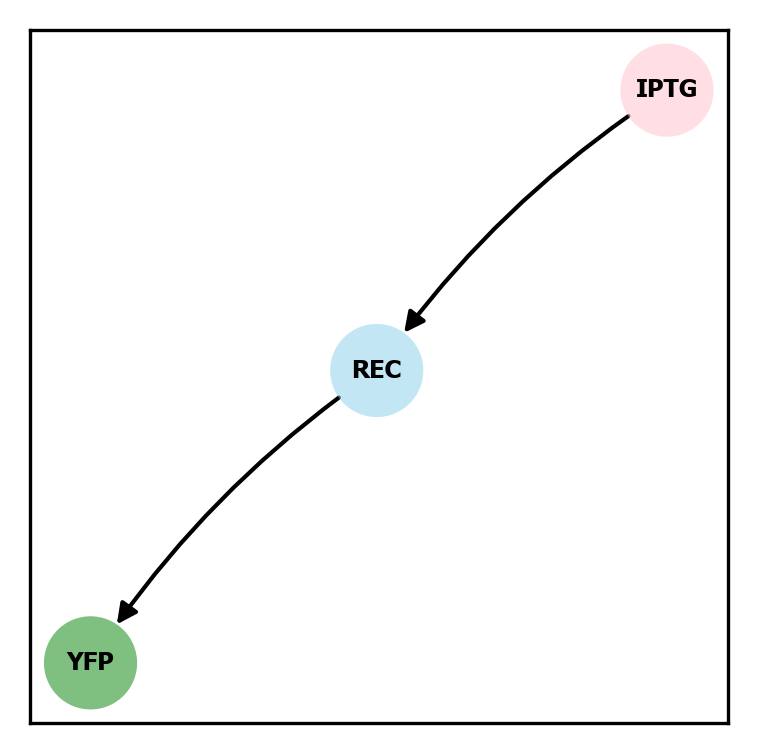

In [4]:
receiver = lc.GeneticNetwork(vector=vector.id[0])

iptg = lc.Supplement(name='IPTG')

yfp_rep = lc.Reporter(name='YFP', degradation_rate=0, signal_id=yfp.id[0], color='green')
receiver.add_reporter(yfp_rep)

iptg_rec_yfp = lc.Receiver(input=iptg, output=yfp_rep, alpha=[1e-3,1e4], K=1e-5, n=2)
receiver.add_operator(iptg_rec_yfp)

plt.figure(figsize=(3,3), dpi=300)
receiver.draw()

In [ ]:
iptg_rec_yfp.characterize( fj,
    vector=vector.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id
)

In [ ]:
iptg_rec_yfp.alpha, iptg_rec_yfp.K, iptg_rec_yfp.n

In [ ]:
iptg_rec_yfp.alpha[1]/iptg_rec_yfp.alpha[0]

In [ ]:
yfp_rep.degradation_rate

# NOT characterization

## SrpR

In [21]:
vector2 = fj.get('vector', name='pSrpR-S3_cyan')

In [22]:
inverter = lc.GeneticNetwork(vector=vector2.id[0])

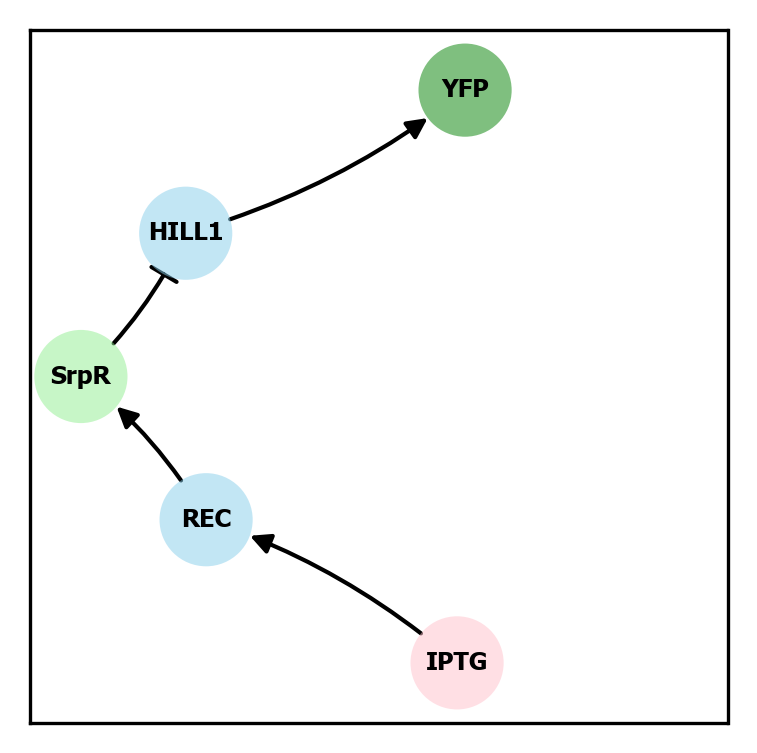

In [23]:
inverter.add_reporter(yfp_rep)

srpr_reg = lc.Regulator('SrpR')
inverter.add_regulator(srpr_reg)

iptg_rec_srpr = iptg_rec_yfp
iptg_rec_srpr.output = srpr_reg
srpr_not_yfp = lc.Hill1(input=srpr_reg, output=yfp_rep, alpha=[1e4,1e-3], K=1e4, n=2)
inverter.add_operator([srpr_not_yfp, iptg_rec_srpr])

plt.figure(figsize=(3,3), dpi=300)
inverter.draw()

In [24]:
srpr_not_yfp.characterize( fj,
    receiver=vector.id,
    inverter=vector2.id,
    study=study.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.97it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.22it/s]


Returning dataframe
Testing func
10000.000000000007 0.0010000000000000002 10000.00000000001 2.0
91629071.99264276
func(x0) = [ 0.00000000e+00  1.27877817e+01 -3.23450208e+01 ...  1.15446600e+05
  1.15808148e+05  1.16912156e+05]
10000.000000000007 0.0010000000000000002 10000.00000000001 2.0
91629071.99264276
10000.000000000007 0.0010000000000000002 10000.00000000001 2.0000000298023224
91629066.17717652
10000.000000000007 0.0010000000000000002 10000.00137244777 2.0
91629054.37592268
10000.00240178371 0.0010000000000000002 10000.00000000001 2.0
91629056.83906394
9999.998970664315 0.000999999897066431 10000.00000000001 2.0
91629065.96837588
9945.563844376316 0.0010026057622226179 10683.597520322104 1.9793470962935473
90375701.3384722
9945.563844376316 0.0010026057622226179 10683.597520322104 1.9793471257881177
90375705.14603482
9945.563844376316 0.0010026057622226179 10683.598997116953 1.9793470962935473
90375740.48635963
9945.566231890996 0.0010026057622226179 10683.597520322104 1.9793470

In [25]:
srpr_not_yfp.alpha, srpr_not_yfp.K, srpr_not_yfp.n

([32505.68573669757, 0.0009902016971662913],
 10341.47292804724,
 1.8985001314210754)

In [ ]:
srpr_not_yfp.alpha[0]/srpr_not_yfp.alpha[1]

In [ ]:
a = srpr_not_yfp.alpha[0]
b = srpr_not_yfp.alpha[1]
K = srpr_not_yfp.K
n = srpr_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## BetI

In [15]:
vector3 = fj.get('vector', name='pBetI-E1_cyan')

 25%|██████████████████▌                                                       | 25/100 [00:03<00:10,  7.44it/s]

In [16]:
inverter_pbeti = lc.GeneticNetwork(vector=vector3.id[0])

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.56it/s]


Returning dataframe


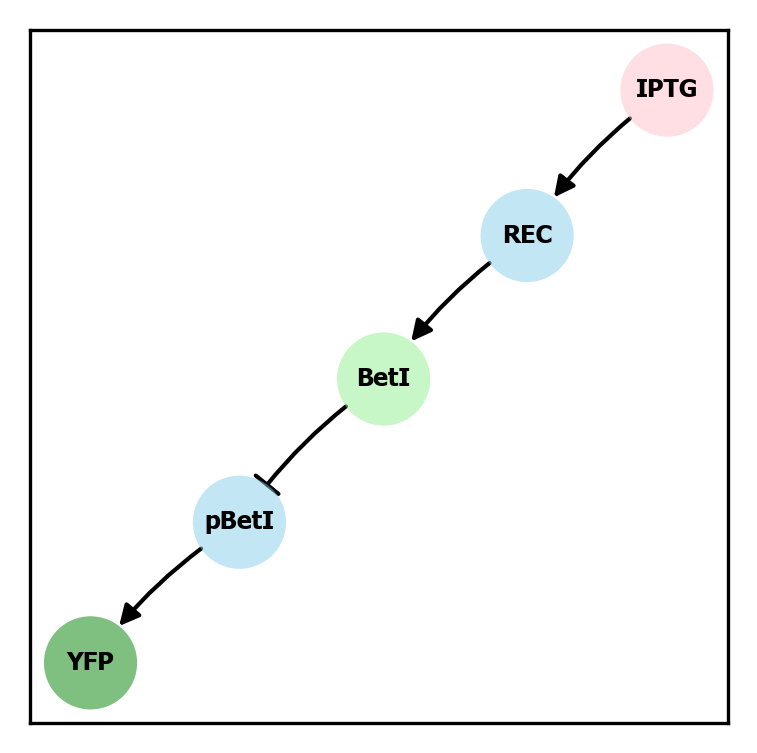

In [17]:
inverter_pbeti.add_reporter(yfp_rep)

beti_reg = lc.Regulator('BetI')
inverter_pbeti.add_regulator(beti_reg)

iptg_rec_beti = iptg_rec_yfp
iptg_rec_beti.output = beti_reg
beti_not_yfp = lc.Hill1(name='pBetI',input=beti_reg, output=yfp_rep, alpha=[1e4,1e-3], K=1e4, n=2)
inverter_pbeti.add_operator([iptg_rec_beti, beti_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_pbeti.draw()

In [18]:
beti_not_yfp.characterize( fj,
    receiver=vector.id,
    inverter=vector3.id,
    study=study.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.19it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


Returning dataframe


100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.36it/s]


Returning dataframe
Testing func
10000.000000000007 0.0010000000000000002 10000.00000000001 2.0
266367162.95365998
func(x0) = [0.00000000e+00 1.79577898e+01 2.51645138e+01 ... 3.72568812e+05
 3.76513234e+05 3.79484185e+05]
10000.000000000007 0.0010000000000000002 10000.00000000001 2.0
266367162.95365998
10000.000000000007 0.0010000000000000002 10000.00000000001 2.0000000298023224
266367158.8607586
10000.000000000007 0.0010000000000000002 10000.00137244777 2.0
266367121.2843821
10000.00240178371 0.0010000000000000002 10000.00000000001 2.0
266367157.3761832
9999.998970664315 0.000999999897066431 10000.00000000001 2.0
266367163.07299468
30102.47859533737 0.001298646398403204 10465.026225929256 2.0016692303485826
195106617.9281735
30102.47859533737 0.001298646398403204 10465.026225929256 2.0016692601757784
195106610.40905774
30102.47859533737 0.001298646398403204 10465.027669287549 2.0016692303485826
195106603.77752304
30102.486202407643 0.001298646398403204 10465.026225929256 2.0016692303

In [19]:
beti_not_yfp.alpha, beti_not_yfp.K, beti_not_yfp.n

([30540.55205321777, 0.0012883584625991442],
 10482.06200281599,
 2.002976104937884)

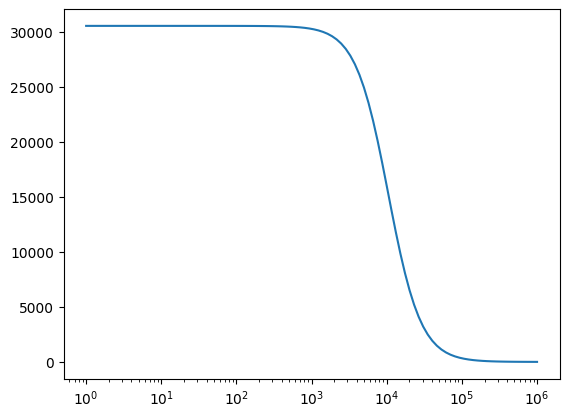

In [20]:
a = beti_not_yfp.alpha[0]
b = beti_not_yfp.alpha[1]
K = beti_not_yfp.K
n = beti_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## QacR

In [ ]:
vector4 = fj.get('vector', name='pQacR_Q1_cyan')

In [ ]:
inverter_pqacr = lc.GeneticNetwork(vector=vector4.id[0])

In [ ]:
inverter_pqacr.add_reporter(yfp_rep)

qacr_reg = lc.Regulator('QacR')
inverter_pqacr.add_regulator(beti_reg)

iptg_rec_qacr = iptg_rec_yfp
iptg_rec_qacr.output = qacr_reg
qacr_not_yfp = lc.Hill1(name='pQacR',input=qacr_reg, output=yfp_rep, alpha=[1e4,1e-3], K=1e4, n=2)
inverter_pqacr.add_operator([iptg_rec_qacr, qacr_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_pqacr.draw()

In [ ]:
qacr_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector4.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)

In [ ]:
qacr_not_yfp.alpha, qacr_not_yfp.K, qacr_not_yfp.n

In [ ]:
a = qacr_not_yfp.alpha[0]
b = qacr_not_yfp.alpha[1]
K = qacr_not_yfp.K
n = qacr_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## pBM3R1-B2_cyan

In [ ]:
vector5 = fj.get('vector', name='pBM3R1-B2_cyan')

In [ ]:
inverter_pbm3r1 = lc.GeneticNetwork(vector=vector5.id[0])

In [ ]:
inverter_pbm3r1.add_reporter(yfp_rep)

bm3r1_reg = lc.Regulator('BM3R1')
inverter_pbm3r1.add_regulator(bm3r1_reg)

iptg_rec_bm3r1 = iptg_rec_yfp
iptg_rec_bm3r1.output = bm3r1_reg
bm3r1_not_yfp = lc.Hill1(name='pBM3R1',input=bm3r1_reg, output=yfp_rep, alpha=[10,1e-3], K=1e3, n=2)
inverter_pbm3r1.add_operator([iptg_rec_bm3r1, bm3r1_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_pbm3r1.draw()

In [ ]:
bm3r1_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector5.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)

In [ ]:
bm3r1_not_yfp.alpha, bm3r1_not_yfp.K, bm3r1_not_yfp.n

In [ ]:
a = bm3r1_not_yfp.alpha[0]
b = bm3r1_not_yfp.alpha[1]
K = bm3r1_not_yfp.K
n = bm3r1_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## lcaRA

In [ ]:
vector6 = fj.get('vector', name='plcaRA_I1_cyan')

In [ ]:
inverter_plcara = lc.GeneticNetwork(vector=vector6.id[0])

In [ ]:
inverter_plcara.add_reporter(yfp_rep)

lcara_reg = lc.Regulator('lcaRA')
inverter_plcara.add_regulator(lcara_reg)

iptg_rec_lcara = iptg_rec_yfp
iptg_rec_lcara.output = lcara_reg
lcara_not_yfp = lc.Hill1(name='plcaRA',input=lcara_reg, output=yfp_rep, alpha=[10,1e-3], K=1e3, n=2)
inverter_plcara.add_operator([iptg_rec_lcara, lcara_not_yfp])

plt.figure(figsize=(3,3), dpi=300)
inverter_plcara.draw()

In [ ]:
lcara_not_yfp.characterize( fj,
    receiver=iptg_rec_yfp,
    inverter=vector6.id,
    media=media.id,
    strain=strain.id,
    signal=yfp.id,
    biomass_signal=biomass_signal.id,
    gamma=0
)

In [ ]:
lcara_not_yfp.alpha, lcara_not_yfp.K, lcara_not_yfp.n

In [ ]:
a = lcara_not_yfp.alpha[0]
b = lcara_not_yfp.alpha[1]
K = lcara_not_yfp.K
n = lcara_not_yfp.n

x=np.logspace(0,6,100)
y= (a + b*(x/K)**n)/(1+(x/K)**n)
plt.plot(x,y)
plt.xscale('log')

## Oscillator

In [ ]:
oscillator = lc.GeneticNetwork(vector=0)

In [ ]:
cfp_rep = lc.Reporter(name='CFP', color='blue', degradation_rate=0)
rfp_rep = lc.Reporter(name='RFP', color='red', degradation_rate=0)
yfp_rep.degradation_rate = 0

oscillator.add_reporter([yfp_rep,cfp_rep,rfp_rep])

oscillator.add_regulator([beti_reg, srpr_reg, qacr_reg])

beti_not_srpr = beti_not_yfp
beti_not_srpr.input = beti_reg
beti_not_srpr.output = [srpr_reg, yfp_rep]
beti_not_srpr.n = 2

srpr_not_qacr = srpr_not_yfp
srpr_not_qacr.input = srpr_reg
srpr_not_qacr.output = [qacr_reg, cfp_rep]
srpr_not_qacr.n = 2

qacr_not_beti = qacr_not_yfp
qacr_not_beti.input = qacr_reg
qacr_not_beti.output = [beti_reg, rfp_rep]
qacr_not_beti.n = 2

oscillator.add_operator([beti_not_srpr, srpr_not_qacr, qacr_not_beti])

plt.figure(figsize=(3,3), dpi=300)
oscillator.draw()

In [ ]:
srpr_reg.init_concentration = 1e4
yfp_rep.init_concentration = 1e4

In [ ]:
def growth_rate(t):
    return 1 #lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return 1 #lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

metab = lc.SimulatedMetabolism(name='LOICA metab', biomass=biomass, growth_rate=growth_rate)

sample = lc.Sample(genetic_network=oscillator, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=10000, 
              interval=0.0025,
              name='LOICA repressilator',
              description='Simulated repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
m[m.Signal=='YFP'].plot(x='Time', y='Measurement', ax=ax, label='YFP', color='g')
m[m.Signal=='CFP'].plot(x='Time', y='Measurement', ax=ax, label='CFP', color='b')
m[m.Signal=='RFP'].plot(x='Time', y='Measurement', ax=ax, label='RFP', color='r')

plt.savefig('LOICARepressilator.png', dpi=300)

# Repressilator generator

In [ ]:
from itertools import permutations 

In [ ]:
srpr_reg = lc.Regulator('SrpR', degradation_rate=1)
beti_reg = lc.Regulator('BetI', degradation_rate=1)
qacr_reg = lc.Regulator('QacR', degradation_rate=1)
bm3r1_reg = lc.Regulator('BM3R1', degradation_rate=1)
lcara_reg = lc.Regulator('lcaRA', degradation_rate=1)

NOT_SrpR = [srpr_reg, srpr_not_yfp.alpha[0], srpr_not_yfp.alpha[1], srpr_not_yfp.K, srpr_not_yfp.n]
NOT_BetI = [beti_reg, beti_not_yfp.alpha[0], beti_not_yfp.alpha[1], beti_not_yfp.K, beti_not_yfp.n]
NOT_QacR = [qacr_reg, qacr_not_yfp.alpha[0], qacr_not_yfp.alpha[1], qacr_not_yfp.K, qacr_not_yfp.n]
NOT_BM3R1 = [bm3r1_reg, bm3r1_not_yfp.alpha[0], bm3r1_not_yfp.alpha[1], bm3r1_not_yfp.K, bm3r1_not_yfp.n]
NOT_lcaRA = [lcara_reg, lcara_not_yfp.alpha[0], lcara_not_yfp.alpha[1], lcara_not_yfp.K, lcara_not_yfp.n]

perms = []
perm = permutations([NOT_SrpR, 
                     NOT_BetI,
                     NOT_QacR,
                     NOT_BM3R1,
                     NOT_lcaRA,
                    ],3)  #with a larger list then we can do ([NOT_1, NOT_2, NOT_3],3)
for i in list(perm):  
    perms.append(i) 

print(perms)

In [ ]:
i=0
def growth_rate(t):
    return 1 #lc.gompertz_growth_rate(t, 0.01, 1, 1, 4)

def biomass(t):
    return 1 #lc.gompertz(t, 0.01, 1, 1, 4)

gfp = lc.Reporter(name='GFP', degradation_rate=0, signal_id=0)

for op in perms:

  rep = lc.GeneticNetwork(vector=0) #add a propoer and identifiable name
  rep.add_regulator([op[0][0],op[1][0], op[2][0]]) #add regulators
  rep.add_reporter(gfp)#[cfp, yfp, rfp]) 
  #build dynamics NOTs, 1000 times to do MEFL
  scalar = 1
  rep.add_operator([
                     lc.Hill1(input=op[0][0], output=op[1][0], alpha=[op[0][1]*scalar,op[0][2]]*scalar, K=op[0][3]*scalar, n=op[0][4]),
                     lc.Hill1(input=op[1][0], output=op[2][0], alpha=[op[1][1]*scalar,op[1][2]]*scalar, K=op[1][3]*scalar, n=op[1][4]),
                     lc.Hill1(input=op[2][0], output=op[0][0], alpha=[op[2][1]*scalar,op[2][2]]*scalar, K=op[2][3]*scalar, n=op[2][4])
                     ])
 
  #build reporter NOTs
  rep.add_operator([
                     lc.Hill1(input=op[0][0], output=gfp, alpha=[op[0][1]*scalar,op[0][2]]*scalar, K=op[0][3]*scalar, n=op[0][4]),
                     #lc.Hill1(input=op[1][0], output=yfp, alpha=[op[1][1]*scalar,op[1][2]]*scalar, K=op[1][3]*scalar, n=op[1][4]),
                     #lc.Hill1(input=op[2][0], output=rfp, alpha=[op[2][1]*scalar,op[2][2]]*scalar, K=op[2][3]*scalar, n=op[2][4])
                     ])
  
  #AS
  metab = lc.SimulatedMetabolism('SimMetab',biomass, growth_rate)

  samples = []
  # Create 3 replicate samples for simulation
  for _ in range(3):
      sample = lc.Sample(genetic_network=rep, 
                      metabolism=metab)
      samples.append(sample)

  assay = lc.Assay(samples, 
              n_measurements=100, 
              interval=0.25,
              name='Loica repressilator',
              description='Simulated repressilator generated by loica',
              biomass_signal_id=0
             )
  assay.run()
  m = assay.measurements
  fig,ax = plt.subplots(1,1)
  m[m.Signal=='GFP'].plot(x='Time', y='Measurement', ax=ax, label='GFP', color='g')
  plt.savefig(f'LOICARepressilator{i}.png', dpi=300)
  i+=1
  

In [ ]:
def growth_rate(t):
    return lc.metabolism.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.metabolism.gompertz(t, 0.01, 1, 1, 1)

#Create the main df that will contain all the generated data
columns = {'Measurement':[], 'Sample':[], 'Signal':[], 'Signal_id':[], 'Time':[]}
repgen_df = pd.DataFrame(columns)

#build reporters
cfp = lc.Reporter(name='CFP', degradation_rate=1, signal_id=0)
yfp = lc.Reporter(name='YFP', degradation_rate=1, signal_id=0)
rfp = lc.Reporter(name='RFP', degradation_rate=1, signal_id=0)


for op in perms:
  #GNC
  rep = lc.GeneticNetwork(vector=0) #add a propoer and identifiable name
  rep.add_regulator([op[0][0],op[1][0], op[2][0]]) #add regulators
  rep.add_reporter([cfp, yfp, rfp]) 
  #build dynamics NOTs, 1000 times to do MEFL
  rep.add_operator([
                     lc.Hill1(input=op[0][0], output=op[1][0], alpha=[op[0][1]*1000,op[0][2]]*1000, K=op[0][3]*1000, n=op[0][4]),
                     lc.Hill1(input=op[1][0], output=op[2][0], alpha=[op[1][1]*1000,op[1][2]]*1000, K=op[1][3]*1000, n=op[1][4]),
                     lc.Hill1(input=op[2][0], output=op[0][0], alpha=[op[2][1]*1000,op[2][2]]*1000, K=op[2][3]*1000, n=op[2][4])
                     ])
 
  #build reporter NOTs
  rep.add_operator([
                     lc.Hill1(input=op[0][0], output=cfp, alpha=[op[0][1]*1000,op[0][2]]*1000, K=op[0][3]*1000, n=op[0][4]),
                     lc.Hill1(input=op[1][0], output=yfp, alpha=[op[1][1]*1000,op[1][2]]*1000, K=op[1][3]*1000, n=op[1][4]),
                     lc.Hill1(input=op[2][0], output=rfp, alpha=[op[2][1]*1000,op[2][2]]*1000, K=op[2][3]*1000, n=op[2][4])
                     ])
  
  #AS
  metab = lc.SimulatedMetabolism('SimMetab',biomass, growth_rate)

  sample = lc.Sample(genetic_network=rep, 
                metabolism=metab,
                media=0,
                strain=0
               )
  assay = lc.Assay([sample], 
              n_measurements=100, 
              interval=0.25,
              name='Loica repressilator',
              description='Simulated repressilator generated by loica',
              biomass_signal_id=0
             )
  assay.run()
  assay.measurements['Sample'] = f'rg_{op[0][0]}_{op[1][0]}_{op[2][0]}'
  repgen_df = repgen_df.append(assay.measurements, ignore_index=True)
  m = assay.measurements
  fig,ax = plt.subplots(1,1)
  m[m.Signal=='CFP'].plot(x='Time', y='Measurement', ax=ax, label=f'{op[0][0]}_{op[0][1]}_cfp')
  m[m.Signal=='YFP'].plot(x='Time', y='Measurement', ax=ax, label=f'{op[1][0]}_{op[1][1]}_yfp')
  m[m.Signal=='RFP'].plot(x='Time', y='Measurement', ax=ax, label=f'{op[2][0]}_{op[2][1]}_rfp')
  plt.savefig(f'LOICARepressilator_{op[0][0]}_{op[1][0]}_{op[2][0]}.png', dpi=300)